# **HW4: Machine Learning Based Investment Strategy For NBA Players Memorabilia**

# **I will now optimize the profit from my previous workflow using new techniques**



In [23]:
# Import Libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split

# Reset Plot Settings
plt.rcdefaults()

In [24]:
NBA_Data = pd.read_csv('NBA_Data.csv',index_col=0)

Adding a function to score by profit

In [25]:
from sklearn.metrics import make_scorer

def profit_scoring(y_true, y_pred):
    # Calculate True Positives (TP) and False Negatives (FN)
    TP = ((y_pred == 1) & (y_true == 1)).sum()
    FN = ((y_pred == 0) & (y_true == 1)).sum()

    # Calculate the profit based on the provided profit/loss values
    profit = TP * 80000 - FN * 20000
    return profit

# Create a scorer that can be used in scikit-learn model selection
profit_scorer = make_scorer(profit_scoring, greater_is_better=True)


In [26]:
def report_score(mymodel, X, y, mycv):
# To use this function, all we need to do is feed it our model of interest, X, y, and the number of folds for cross-validation.

    # Calculate and print the cross-validation accuracy
    cross_val_accuracy = round(cross_val_score(mymodel, X, y, cv = mycv).mean()*100,2)
    print(f"{mycv}-Fold Cross-Validation Classification Accuracy: {cross_val_accuracy:.2f}%")

    # Calculate and print the cross-validation ROC AUC
    cross_val_accuracy_roc_auc = round(cross_val_score(mymodel, X, y, cv =  mycv, scoring = 'roc_auc').mean()*100,2)
    print(f"\n{mycv}-Fold Cross-Validation ROC AUC: {cross_val_accuracy_roc_auc:.2f} %")

## FEATURE SELECTION ##

#### Let's fill in the missing values for the Minutes feature for feature selection ####

In [27]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold, cross_val_score

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold, cross_val_score

data = NBA_Data.copy()

# Replace 0s with NaN in the 'minutes' column
data['minutes'] = data['minutes'].replace(0, np.nan)

# Prepare the dataset with non-missing values to train the model
train_data = data[data['minutes'].notna()]

features = ['games', 'pts', 'reb', 'asts', 'stl', 'fta', 'tpm', 'firstSeason', 'lastSeason', 'yrsRetired2004', 'league_N', 'Position_C', 'Position_F', 'Position_G']


X_train = train_data[features]
y_train = train_data['minutes']

# Initialize the Random Forest model with the optimal parameters
rf_model = RandomForestRegressor(max_depth=None, max_features='sqrt', min_samples_leaf= 1, min_samples_split=2, n_estimators=200,random_state=3
)
# Initialize the Iterative Imputer with Random Forest as the estimator
imputer = IterativeImputer(estimator=RandomForestRegressor(max_depth=None, max_features='sqrt', 
                                                           min_samples_leaf=1, min_samples_split=2, 
                                                           n_estimators=200, random_state=3), 
                           random_state=3)

# Prepare dataset with features and target for imputation
full_data = data[features + ['minutes']]

# Fit the imputer on the dataset
imputer.fit(full_data)

# Transform the dataset (impute missing values)
imputed_data = imputer.transform(full_data)

# Convert imputed data back to DataFrame
imputed_data_df = pd.DataFrame(imputed_data, columns=features + ['minutes'])

# Update original data frame with imputed 'minutes'
data.update(imputed_data_df['minutes'])

# Standard deviation after imputation
std_dev_new = data['minutes'].std()
std_dev_original = NBA_Data['minutes'].std()

# Preparing the training data from the imputed dataset
X_train = imputed_data_df[features]
y_train = imputed_data_df['minutes']

# Re-train the Random Forest model on the imputed dataset
rf_model.fit(X_train, y_train)

# Cross-validation to evaluate the model
kf = KFold(n_splits=5, shuffle=True, random_state=3)
mse_scores = -cross_val_score(rf_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
average_mse = np.mean(mse_scores)
average_rmse = np.sqrt(average_mse)

print(f"Average MSE from cross-validation: {average_mse}")
print(f"Average RMSE from cross-validation: {average_rmse}")
print(f"Standard Deviation of imputed 'minutes': {std_dev_new}")
print(f"Standard Deviation of original 'minutes': {std_dev_original}")


Average MSE from cross-validation: 1855478.2880716217
Average RMSE from cross-validation: 1362.1594209458824
Standard Deviation of imputed 'minutes': 9677.173459442944
Standard Deviation of original 'minutes': 9720.614594024819


In [28]:
data['Assists Per Minute'] = np.where(data['minutes'], data['asts'] / data['minutes'], 0)
data['Points Per Minute'] = np.where(data['minutes'], data['pts'] / data['minutes'], 0)
data['Rebounds Per Minute'] = np.where(data['minutes'], data['reb'] / data['minutes'], 0)

In [29]:
x_tesing = data[['minutes', 'pts', 'stl', 'blk', 'fga', 'ftm', 'tpa', 'totalSeasons', 'firstSeason', 'lastSeason', 'careerEnded', 'league_N', 'Position_C', 'Position_G', 'Points Per Minute']]
y = data['class']
ran = RandomForestClassifier(bootstrap = False, max_depth = None, max_features= 'sqrt', max_leaf_nodes = 50, min_samples_leaf= 1, min_samples_split = 5, n_estimators= 50,random_state=3).fit(x_tesing, y)
                                #max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200

report_score(ran, x_tesing, y, 10)


10-Fold Cross-Validation Classification Accuracy: 97.37%

10-Fold Cross-Validation ROC AUC: 99.37 %


In [30]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# # Define a more comprehensive parameter grid
# param_grid = {
#     'n_estimators': [10, 50, 100, 200, 300],  # More options for number of trees
#     'max_depth': [None, 10, 20, 30, 50, 70],  # Broader range for maximum depth
#     'min_samples_leaf': [1, 2, 4, 6],  # More granular steps for min_samples_leaf
#     'min_samples_split': [2, 5, 10, 15],  # More options for min_samples_split
#     'max_features': ['sqrt', 'log2', None],  # Different options for number of features to consider
#     'bootstrap': [True, False],  # Whether or not to bootstrap the sampling of data points
#     'max_leaf_nodes': [None, 10, 50, 100, 200]  # Limits on the number of leaf nodes
# }

# # Create the GridSearchCV object with random_state for reproducibility
# grid_search_auc = GridSearchCV(estimator=RandomForestClassifier(random_state=3),
#                                param_grid=param_grid,
#                                cv=10,  # 10-fold cross-validation
#                                scoring='roc_auc',  # Using ROC AUC as the metric
#                                n_jobs=-1,  # Use all available CPUs
#                                verbose=2)

# # Assume x_tesing and y are already defined and preprocessed
# grid_search_auc.fit(x_tesing, y)

# # After fitting, print out the best parameters and best score achieved
# print("Best parameters found: ", grid_search_auc.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search_auc.best_score_))


In [31]:
# Get the best parameters
# best_params = grid_search_auc.best_params_
# # Get the best score achieved
# best_score = grid_search_auc.best_score_

# print(f"Best Parameters: {best_params}")
# print(f"Best AUC Score: {best_score}")

### Let's use the following wrapper method to pick features ###

In [32]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV, cross_val_score  # Corrected import here

# # Define your model
# classifier = RandomForestClassifier(random_state=3)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],      # Number of trees in the forest
#     'max_features': ['sqrt', 'log2', None],  # Number of features to consider at every split
#     'max_depth': [None, 10, 20, 30],     # Maximum number of levels in each tree
#     'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4]        # Minimum number of samples required at each leaf node
# }

# # Setup the grid search
# grid_search = GridSearchCV(estimator=classifier,
#                            param_grid=param_grid,
#                            cv=5,  # Consistency with report_score's CV
#                            scoring='roc_auc',  # Using ROC AUC to match the reporting function's secondary metric
#                            verbose=2,
#                            n_jobs=-1)

# # Assume x_tesing and y are already defined and preprocessed
# grid_search.fit(x_tesing, y)

# # Output the best parameters and the best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))




In [33]:
prob_df = pd.DataFrame()
prob_df['Actual Class'] = y
prob_df['prob'] = [round(pred[1],4) for pred in cross_val_predict(ran, x_tesing, y, cv=10, method='predict_proba')]
prob_df = prob_df.sort_values("prob", ascending=False)

# Initialize dictionary to store profits for each threshold
profit_rf = {}

# Calculate profits for each threshold for Random Forest
for threshold in sorted(prob_df['prob'].unique(), reverse=True):
    # Customers targeted above the threshold
    targeted = prob_df[prob_df['prob'] >= threshold]
    TP = targeted['Actual Class'].sum()  # True Positives
    FP = len(targeted) - TP  # False Positives
    profit = TP * 80000 - FP * 20000  # Profit calculation
    
    # Storing profit for the current threshold
    profit_rf[threshold] = profit

# Identifying the optimal threshold for Random Forest
optimal_threshold_rf = max(profit_rf, key=profit_rf.get)

# Print optimal thresholds and corresponding profits for Random Forest
print(f"Random Forest Optimal Threshold: {optimal_threshold_rf}, Profit: ${profit_rf[optimal_threshold_rf]}")

Random Forest Optimal Threshold: 0.36, Profit: $3020000


# PROFIT IS $3020000 #

## PROFIT CHART ##

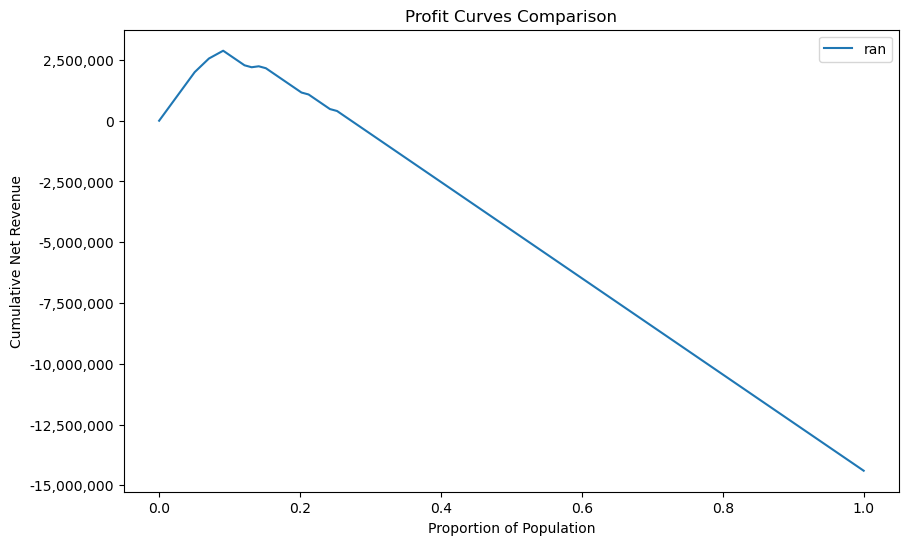

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import cross_val_predict

def plot_profit_curve(model, X, y, cost_matrix, n_points=100, ax=None, label=None):
    # Get predicted probabilities using cross-validation
    prob_pred = cross_val_predict(model, X, y, cv=10, method='predict_proba')

    # Prepare the data
    result = pd.DataFrame({'true': y, 'predicted_probabilities': prob_pred[:, 1]})
    sort = result.sort_values('predicted_probabilities', ascending=False)

    thresh_rang = np.linspace(0, 1, n_points)
    profits = []

    # Calculate profits for each threshold
    for i in thresh_rang:
        subset = sort.head(int(len(sort) * i))
        TP = (subset['true'] == 1).sum()
        FP = len(subset) - TP
        profit = TP * cost_matrix[0] + FP * cost_matrix[1]
        profits.append(profit)

    # Plotting
    if ax is None:
        ax = plt.gca()
    ax.plot(thresh_rang, profits, label=label)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define cost matrix
cost_matrix = np.array([80000, -40000])

# Assuming X_training, y_training are defined and models are already fitted
# Plot profit curves for each model
plot_profit_curve(ran, x_tesing, y, cost_matrix, ax=ax, label='ran')

# Set y-axis to display full integers
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Finalizing the plot
ax.set_xlabel('Proportion of Population')
ax.set_ylabel('Cumulative Net Revenue')
ax.legend()
ax.set_title('Profit Curves Comparison')
plt.show()

## SELECTED PLAYERS ##

In [35]:
import pandas as pd
from sklearn.model_selection import cross_val_predict

# Set display options for better DataFrame printouts
pd.set_option('display.max_rows', None)  # Adjust based on your dataset size
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 4)


prob_df = pd.DataFrame()
prob_df['Actual Class'] = y
prob_df['Probability'] = [round(pred[1], 4) for pred in cross_val_predict(ran, x_tesing, y, cv=10, method='predict_proba')]
prob_df = prob_df.sort_values("Probability", ascending=False)


profit_rf = {}

# Calculate profits for each threshold
for threshold in sorted(prob_df['Probability'].unique(), reverse=True):
    # Customers targeted above the threshold
    targeted = prob_df[prob_df['Probability'] >= threshold]
    TP = targeted['Actual Class'].sum()  
    FP = len(targeted) - TP  
    profit = TP * 80000 - FP * 20000  
    
    # Storing profit for the current threshold
    profit_rf[threshold] = profit

# Identifying the optimal threshold
optimal_threshold_rf = max(profit_rf, key=profit_rf.get)

# Output optimal threshold and profit
print(f"Random Forest Optimal Threshold: {optimal_threshold_rf}, Profit: ${profit_rf[optimal_threshold_rf]:,}")

# Select and display players above the optimal threshold
selected_players = prob_df[prob_df['Probability'] >= optimal_threshold_rf]
selected_players = selected_players[['Probability']].sort_values('Probability', ascending=False)
print("\nSelected Players:")
print(selected_players)


Random Forest Optimal Threshold: 0.36, Profit: $3,020,000

Selected Players:
     Probability
96     1.0000   
464    1.0000   
228    1.0000   
209    0.9933   
73     0.9933   
274    0.9900   
347    0.9850   
104    0.9800   
114    0.9800   
353    0.9800   
397    0.9700   
482    0.9683   
301    0.9633   
38     0.9633   
87     0.9450   
355    0.9450   
53     0.9400   
168    0.9300   
487    0.9250   
287    0.9117   
204    0.9117   
6      0.9000   
35     0.8950   
309    0.8850   
480    0.8833   
14     0.8817   
244    0.8817   
24     0.8600   
80     0.8367   
359    0.8283   
143    0.7767   
176    0.7283   
142    0.6883   
492    0.6783   
392    0.6700   
46     0.6500   
10     0.6317   
340    0.6100   
175    0.6083   
394    0.5883   
484    0.4750   
466    0.4233   
112    0.3783   
427    0.3600   
